<img src="pylogo.PNG" alt="Logo" style="width: 500px;"/>

# 006 - PyLadiesMadrid: Procesamiento del Lenguaje Natural

### **Claudia Guirao Fernández**
_Data Scientist @ Kernel Analytics_


### (Adding more code: Ana Valdivia (@ana_valdi))

Objetivos de hoy:
* Introducir las herramientas y librerías de text mining y NLP en Python
* Ver cómo se pueden realizar estas operaciones en Python
* Descubrir con un corpus en Español algunas curiosidades interesantes sobre los Premios Goya al cine español

## 1. _Basics_ sobre string en Python

In [1]:
mystring = '¡Hola Salamanca!'
mystring2 = "¡Hola 'Salamanca'!"
print(mystring2)

¡Hola 'Salamanca'!


In [2]:
print(str(len(mystring)) + ' longitud de la cadena') 
print(str(mystring.index("o")) + ' posición')  #primera ocurrencia
print(str(mystring.count("a")) + ' veces') #contar el número de ocurrencias

16 longitud de la cadena
2 posición
5 veces


In [3]:
print(mystring.upper())
print(mystring.lower())

¡HOLA SALAMANCA!
¡hola salamanca!


In [4]:
print(mystring[4])
print(mystring[1:5])
print(mystring[::-1])

a
Hola
!acnamalaS aloH¡


Más información: [Basic String Operations](https://www.learnpython.org/en/Basic_String_Operations)

## 2. Conceptos básicos al trabajar con texto

* **corpus**: conjunto estructurado de textos / documentos 
* **stopwords**: es castellano "palabras vacías", se filtran de los análisis por su escaso aporte/significado 


**Normalizar**: el texto consiste en unificar la forma de los textos. Para ello hay distintas operaciones y algoritmos que pueden ayudarnos. 
1. **tokenizar**: operación consistente en identificar las distintas unidades o tokens, en una frase identificamos las distintas palabras
2. **stemming**: consiste en reducir las palabras a su tema (Algoritmo de Porter, Snowball, entre otros)
3. **lematizar**: es un proceso lingüístico que consiste en, dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra

_¿Qué es mejor lematizar o hacer stemming? ¿qué algoritmos funcionan mejor?_

Operaciones con el texto normalizado:

* **TF**: Calcular la frecuencia de aparición de los términos en uno o varios documentos
* **n-gramas**: conjuntos de n palabras que aparecen en el mismo documento
* **TF-IDF**:  frecuencia de término – frecuencia inversa de documento (o sea, la frecuencia de ocurrencia del término en la colección de documentos), es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección

## 3. Librerías más comunes para el tratamiento de texto

* [**NLTK**](https://www.nltk.org/): Librería principal para el procesamiento de texto en Python. Dispone de un [manual online](http://www.nltk.org/book/). Posee una interfaz sencilla y cubre la mayor parte de las operaciones. Fue la primera y es de las más extendidas. 
* [**Textblob**](http://textblob.readthedocs.io/en/dev/) : De nuevo cumple bastantes de las operaciones de procesamiento del lenguaje, está construida sobre NLTK y pretende ser más intuitiva que la ésta. Incluye un módulo de traducción y detección del idioma. [Ver tutorial](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/) Es la segunda en velocidad por delante de NLTK.
* [**SpaCy**](https://spacy.io): es la librería más reciente, su interfaz es muy fácil de utilizar. Posee bastantes modelos ya entrenados incluyendo _deep learning_

_(las tres soportan multiples idiomas, quizá SpaCy es la más limitada porque lleva menos años disponible, aunque todas soportan el castellano)_

* [**Gensim**](https://radimrehurek.com/gensim/): Complemento de las anteriores, especialmente centrada en el modelado de temática (LDA)

<img src="comparativa.PNG" alt="Comparativa" style="width: 600px;"/>

### ¿Cómo instalar las librerías?

```conda install -c conda-forge spacy```


```python -m spacy download es```



```conda install -c anaconda nltk```

```conda install -c anaconda gensim ```

In [5]:
# nltk.download()

## 4. Let's play

Importamos las librerías necesarias

In [6]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import nltk
import spacy
import gensim
import re
import os
import codecs
from sklearn import feature_extraction
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Cargamos el modelo en español para SpaCy

In [7]:
import es_core_news_sm
nlp = es_core_news_sm.load()

Importar wordnet, un giant lexicon.

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/avaldivia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Importamos el fichero de texto que contiene la sinopsis para las películas nominadas desde la edición 14 de los premios.

Para obtener esta información he _escrapeado_ la web oficial de los [Premios Goya](premiosgoya.com)

In [9]:
info_pelis = pd.read_csv("sinopsis_nominados_goya.csv",encoding='latin-1')

Al hacer el scrapping de la web el texto contiene algunas cosas que nos gustaría eliminar antes de comenzar

In [10]:
def clean_Goya(tit):
    return(' '.join(tit.split()))
    
info_pelis['titulo'] = info_pelis.titulo.apply(clean_Goya)
info_pelis['descripcion'] = info_pelis.descripcion.apply(clean_Goya)

Cargamos el fichero que contiene si las películas han sido nominadas o ganadoras en la categoría mejor película o mejor dirección y añadimos esas columnas a nuestro _dataframe_ original

In [11]:
premios = pd.read_csv("titulo_edicion.csv", encoding='latin-1', sep=';')
info_pelis = pd.merge(info_pelis, premios[['titulo','edicion','nom_mejor_pelicula','gana_mejor_pelicula','nom_mejor_direc','gana_mejor_direc']], on = ['titulo', 'edicion'], how='inner')
info_nominadas = info_pelis[(info_pelis.nom_mejor_pelicula == 1) | (info_pelis.nom_mejor_direc==1)]
print(str(len(info_nominadas)) + ' peliculas nominadas a mejor película o a mejor dirección')

82 peliculas nominadas a mejor película o a mejor dirección


In [12]:
display(info_pelis.head())

,descripcion,edicion,titulo,url_peli,nom_mejor_pelicula,gana_mejor_pelicula,nom_mejor_direc,gana_mejor_direc
0,"Álvaro quiere ser escritor, pero todo lo que e...",32,El autor,https://www.premiosgoya.com/pelicula/el-autor,1.0,0.0,1.0,0.0
1,"Frida, una niña de seis años, afronta el prime...",32,Estiu 1993,https://www.premiosgoya.com/pelicula/estiu-1993,1.0,0.0,0.0,0.0
2,Tras haber luchado en la Primera Guerra Carlis...,32,Handia,https://www.premiosgoya.com/pelicula/handia,1.0,0.0,1.0,0.0
3,A finales de los años 50 Florence Green decide...,32,La librería,https://www.premiosgoya.com/pelicula/la-libreria,1.0,1.0,1.0,1.0
4,"Madrid, años 90. En plena noche, la policía re...",32,Verónica,https://www.premiosgoya.com/pelicula/veronica,1.0,0.0,1.0,0.0


Este es el tipo de información con la que vamos a trabajar:

In [13]:
print(info_nominadas.iloc[0].titulo)
print('............')
print(info_nominadas.iloc[0].descripcion)

El autor
............
Álvaro quiere ser escritor, pero todo lo que escribe es falso, pretencioso, insípido. Trabaja como escribiente en una notaría de Sevilla y su vida es gris, coloreada sólo por sus sueños. Su mujer, Amanda, es todo lo contrario. Siempre ha tenido los pies en la tierra y nunca ha soñado con ser escritora. Sin embargo, es ella la que se pone a escribir y le sale un best-seller. Ironías de la vida. La separación es inevitable. Y en ese momento, Álvaro decide afrontar su sueño: escribir una gran novela. Pero es incapaz; no tiene talento ni imaginación. Guiado por Juan, su profesor de escritura, indaga en los fundamentos de la novela, hasta que un día descubre que la ficción se escribe con la realidad. Álvaro comienza a manipular a sus vecinos y amistades para crear una historia, una historia real que supera a la ficción.


In [14]:
print(info_nominadas.iloc[1].titulo)
print('............')
print(info_nominadas.iloc[1].descripcion)

Estiu 1993
............
Frida, una niña de seis años, afronta el primer verano de su vida con su nueva família adoptiva, tras la muerte de su madre.


### Entidades

Vamos a localizar entidades mediante SpaCy, de una forma muy sencilla.

In [15]:
doc = nlp(info_nominadas.iloc[1].descripcion)
print([(w.text, w.pos_) for w in doc])

[('Frida', 'PROPN'), (',', 'PUNCT'), ('una', 'DET'), ('niña', 'NOUN'), ('de', 'ADP'), ('seis', 'NUM'), ('años', 'NOUN'), (',', 'PUNCT'), ('afronta', 'VERB'), ('el', 'DET'), ('primer', 'ADJ'), ('verano', 'NOUN'), ('de', 'ADP'), ('su', 'DET'), ('vida', 'NOUN'), ('con', 'ADP'), ('su', 'DET'), ('nueva', 'ADJ'), ('família', 'NOUN'), ('adoptiva', 'ADJ'), (',', 'PUNCT'), ('tras', 'ADP'), ('la', 'DET'), ('muerte', 'NOUN'), ('de', 'ADP'), ('su', 'DET'), ('madre', 'NOUN'), ('.', 'PUNCT')]


También es posible visualizar esta información y las relaciones entre términos mediante **displacy**

<img src="Frida.PNG" alt="Comparativa" style="width: 1200px;"/>

In [16]:
# from spacy import displacy
# displacy.serve(doc, style='dep')

Para cada documento SpaCy nos ofrece mucha otra información:

In [17]:
mytokens = []
for token in doc:
    mytokens.append({'text': token.text, 'lemma': token.lemma_, 'pos': token.pos_,'tag':token.tag_,'dep':token.dep_,
          'shape':token.shape_, 'is_alpha': token.is_alpha, 'is_stop': token.is_stop})
pd.DataFrame(mytokens)


,dep,is_alpha,is_stop,lemma,pos,shape,tag,text
0,nsubj,True,False,Frida,PROPN,Xxxxx,PROPN___,Frida
1,punct,False,False,",",PUNCT,",",PUNCT__PunctType=Comm,","
2,det,True,True,uno,DET,xxx,DET__Definite=Ind|Gender=Fem|Number=Sing|PronT...,una
3,appos,True,False,niño,NOUN,xxxx,NOUN__Gender=Fem|Number=Sing,niña
4,case,True,True,de,ADP,xx,ADP__AdpType=Prep,de
5,nummod,True,True,seis,NUM,xxxx,NUM__Number=Plur|NumType=Card,seis
6,nmod,True,False,año,NOUN,xxxx,NOUN__Gender=Masc|Number=Plur,años
7,punct,False,False,",",PUNCT,",",PUNCT__PunctType=Comm,","
8,ROOT,True,False,afrontar,VERB,xxxx,VERB__Mood=Ind|Number=Sing|Person=3|Tense=Pres...,afronta
9,det,True,True,el,DET,xx,DET__Definite=Def|Gender=Masc|Number=Sing|Pron...,el


### Stopwords

_¿Qué entendemos por palabras vacías?_

Cargamos las stopwords predefinidas en español en NLTK 

In [18]:
stopwords_spa = nltk.corpus.stopwords.words('spanish')
print(len(stopwords_spa))
print(stopwords_spa[0:21])

313
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como']


Idéntica operación en SpaCy

In [19]:
from spacy.lang.es.stop_words import STOP_WORDS
print(len(STOP_WORDS))
print(list(STOP_WORDS)[0:21])

551
['sí', 'ya', 'nuestro', 'están', 'verdad', 'fui', 'han', 'de', 'cómo', 'cuanto', 'podria', 'manera', 'nosotros', 'estará', 'ese', 'fuera', 'hizo', 'dicen', 'sido', 'usar', 'su']


Como primera operación vamos a calcular la frecuencia en la que aparece cada término. Excluyendo aquellos que son stopwords, nombres propios o particulas

In [20]:
from __future__ import print_function, unicode_literals
import spacy
from collections import defaultdict, Counter

pos_counts = defaultdict(Counter)
words = []
for sinop in info_pelis.descripcion:
    doc = nlp(sinop)
    for token in doc:
        if token.is_stop != True and token.is_punct != True and token.pos_ not in ['PROPN', 'CONJ', 'ADP', 'DET']:
            words.append(token.lemma_)
word_TF = Counter(words)
word_TF = pd.DataFrame.from_dict(word_TF, orient='index').reset_index()
word_TF = word_TF.rename(index=str, columns={"index": "token", 0: "TF"})
word_TF = word_TF.sort_values('TF', ascending=False)

Las 10 palabras más frecuentes son:

In [21]:
display(word_TF.head(10))

,token,TF
1932,vida,391
4021,año,332
2330,vivir,205
1993,joven,202
4235,hijo,176
2293,historia,171
6285,casar,155
6268,mujer,155
3279,llegar,146
5284,mundo,142


In [22]:
display(word_TF[word_TF.token.isin(['cine', 'director', 'español', 'película', 'vida', 
                                  'vivir', 'mujer', 'hombre', 'joven', 'hijo', 'madre', 'padre'])])

,token,TF
1932,vida,391
2330,vivir,205
1993,joven,202
4235,hijo,176
6268,mujer,155
2343,padre,130
5941,hombre,109
1220,madre,96
2115,película,81
6324,cine,36


En el contexto en el que estamos trabajando conviene añadir algunas otras palabras muy comunes en las sinopsis

In [23]:
MY_STOP_WORDS = STOP_WORDS.copy()
MY_STOP_WORDS = MY_STOP_WORDS.union(['cine','actor','director','español','película','documental','historia',
                                     'vida','vivir','año','vivir', 'mujer', 'hombre', 'joven', 'hijo', 'madre', 
                                     'padre', 'niño','niña', 'hijo', 'hija', 'y', 'e', 'a', 'o' ])

### Stemmers y lematizadores

NLTK ofrece distintos _stemmers_ y _lemmatizers_ con un rendimiento desigual en español:

1. Cargamos uno de los stemmer de NLTK: [SnowballStemmer](https://snowballstem.org/algorithms/spanish/stemmer.html)

In [24]:
from nltk.stem.snowball import SnowballStemmer
stemmer_eng = SnowballStemmer("english")
stemmer = SnowballStemmer("spanish")

In [25]:
print(stemmer_eng.stem('girls'))
print(stemmer.stem('chicas'))

girl
chic


In [26]:
from nltk.stem import WordNetLemmatizer


In [27]:
wordnet_lemmatizer = WordNetLemmatizer()


In [28]:
print(wordnet_lemmatizer.lemmatize('girls'))
print(wordnet_lemmatizer.lemmatize('chica'))

girl
chica


En SpaCy sólo se han desarrollado lematizadores, aquí un interesante hilo en GitHub [Built-in stemmer?](https://github.com/explosion/spaCy/issues/327)

In [29]:
doc = nlp('chica')
for token in doc:
    print(token.lemma_.lower())

chico


## 5. Clustering (NLTK, SpaCy, Sklearn)

En este apartado vamos a tratar de identificar segmentos de películas agrupando mediante las sinopsis. Esta operación puede apoyarse tanto en las funciones disponibles en NLTK como en SpaCy. 

### 5.1. Funciones para tokenizar y lematizar. 

Funciones con NLTK

In [30]:
def tokenize_and_stem(text):
    # Primero se extraen los tokens de una frase, despues se extraen las palabras, 
    # para asegurar que la puntuación toma su propio tokent 
    
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # Solo tomamos los tokens que contienen letras, para evitar tokens numericos y puntuacion
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens] # se extrae el tema para cada palabra
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Funciones son SpaCy

In [31]:
def tokenize_and_lemm_spacy(text):
    doc = nlp(text)
    lemmas = []
    for token in doc:
        if token.is_stop== False: # aprovechamos para eliminar ya las stopwords
            if token.is_alpha== True: # Nos quedamos solo con los tokens que contienen letras 
                if token.pos_ not in ['PROPN', 'CONJ', 'ADP', 'DET']: # eliminamos nombres propios, conjunciones, determinantes
                    lemmas.append(token.lemma_.lower())
    return lemmas

def tokenize_only_spacy(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_stop== False :
            if token.is_alpha== True:
                if token.pos_ not in ['PROPN', 'CONJ', 'ADP', 'DET']:
                    tokens.append(token.text.lower())
    return tokens

In [32]:
print(info_nominadas.iloc[1].descripcion)
print(tokenize_only(info_nominadas.iloc[1].descripcion))
print(tokenize_and_stem(info_nominadas.iloc[1].descripcion))

Frida, una niña de seis años, afronta el primer verano de su vida con su nueva família adoptiva, tras la muerte de su madre.
['frida', 'una', 'niña', 'de', 'seis', 'años', 'afronta', 'el', 'primer', 'verano', 'de', 'su', 'vida', 'con', 'su', 'nueva', 'família', 'adoptiva', 'tras', 'la', 'muerte', 'de', 'su', 'madre']
['frid', 'una', 'niñ', 'de', 'seis', 'años', 'afront', 'el', 'prim', 'veran', 'de', 'su', 'vid', 'con', 'su', 'nuev', 'famili', 'adopt', 'tras', 'la', 'muert', 'de', 'su', 'madr']


In [33]:
print(info_nominadas.iloc[1].descripcion)
print(tokenize_only_spacy(info_nominadas.iloc[1].descripcion))
print(tokenize_and_lemm_spacy(info_nominadas.iloc[1].descripcion))

Frida, una niña de seis años, afronta el primer verano de su vida con su nueva família adoptiva, tras la muerte de su madre.
['niña', 'años', 'afronta', 'verano', 'vida', 'família', 'adoptiva', 'muerte', 'madre']
['niño', 'año', 'afrontar', 'verano', 'vida', 'família', 'adoptivo', 'muerte', 'madre']


### 5.2. Análisis sobre nuestro corpus

Vamos a crear una lista con todas nuestras sinopsis

#### 5.2.1. tf*idf

In [34]:
synopses = list(info_pelis['descripcion'])

Así como una lista de todos los términos encontrados:

In [35]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_lemm_spacy(i)
    totalvocab_stemmed.extend(allwords_stemmed) 
    
    allwords_tokenized = tokenize_only_spacy(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Con estas dos listas, de tokens y lemas, vamos a crear un DataFrame, que contendrá el lema y en el índice el token. Así podemos rescatar en cualquier momento el token original.

In [36]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print( str(vocab_frame.shape[0]) + ' en el vocab_frame')

28373 en el vocab_frame


In [37]:
vocab_frame.head(10)

,words
escritor,escritor
escribir,escribe
falso,falso
pretencioso,pretencioso
insípido,insípido
escribiente,escribiente
notar,notaría
vida,vida
gris,gris
colorear,coloreada


A continuación definimos los parametros para la función de frecuencia inversa (tf-idf), para poder convertir la lista de sinopsis en una matriz de términos y documentos. 

Para alcanzar esta matriz, en primer lugar contamos el número de veces que ocurre una palabra en un documento. Así obtenemos una matriz de términos documentos. 

<img src="tfidf.png" alt="dtm" style="width: 350px;"/>

A continuación esta matriz es ponderada por la frecuencia inversa: palabras que ocurren frecuentemente en un documento pero no en el corpus reciben un peso mayor, asumiendo que aportan un mayor significado en el documento.

Sobre los parámetros:
* **max_df**:  Es la máxima frecuencia dentro de los documentos que un _feature_ dado puede ser utilizado en la matriz tfi-idf. Si fijamos aquí un umbral mayor al 80% probablemente contenga poco significado, al menos en el contexto de este análisis. 
* **min_idf**: Puede tomar un porcentaje o un entero. Por ejemplo 3, en ese caso debe aparecer al menos 3 documentos para ser considerado. 
* **ngram_range**: Vamos a fijarnos solo en unigramas, no en bigramas o trigramas

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=3, stop_words=MY_STOP_WORDS,
                                 use_idf=True, tokenizer=tokenize_and_lemm_spacy, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 29 s, sys: 80 ms, total: 29 s
Wall time: 29.1 s
(921, 2439)


_terms_ contiene la lista de features con la que vamos a realizar el cluster

In [39]:
terms = tfidf_vectorizer.get_feature_names()

Calculamos la distancia como 1- similaridad coseno, esto es la medida de similaridad entre nuestros documentos. La resta nos permitirá representarlo en el plano 

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

#### 5.2.2. word2vec

Entrenamos el modelo word2vec.

In [41]:
sents = [[word for word in document.lower().split()] for document in info_pelis.descripcion]

In [42]:
sents = [[w.replace("\x93", "") for w in sent] for sent in sents] 
sents = [[w.replace("\x94", "") for w in sent] for sent in sents] 
sents = [[w.replace(".", "") for w in sent] for sent in sents] 
sents = [[w.replace("(", "") for w in sent] for sent in sents] 
sents = [[w.replace(")", "") for w in sent] for sent in sents] 
sents = [[w.replace("?", "") for w in sent] for sent in sents] 
sents = [[w.replace("¿", "") for w in sent] for sent in sents] 
sents = [[w.replace(",", "") for w in sent] for sent in sents]
sents = [[w for w in sent if w != MY_STOP_WORDS] for sent in sents]

In [43]:
word2vec_model = gensim.models.Word2Vec(
                                sents,
                                size = 300,
                                window = 5,
                                min_count = 2,
                                workers=4
                                )

In [44]:
word2vec_model.most_similar(positive=['amor'], topn=10)

/home/avaldivia/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('del', 0.9999880790710449),
 ('por', 0.9999879598617554),
 ('se', 0.9999878406524658),
 ('como', 0.999987781047821),
 ('al', 0.9999871850013733),
 ('una', 0.999987006187439),
 ('para', 0.999987006187439),
 ('y', 0.9999869465827942),
 ('con', 0.9999868273735046),
 ('joven', 0.9999867677688599)]

In [45]:
word2vec_model.most_similar(positive=['guerra'], topn=10)

/home/avaldivia/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('al', 0.9999862909317017),
 ('con', 0.9999858736991882),
 ('años', 0.9999858140945435),
 ('por', 0.9999855756759644),
 ('del', 0.9999853372573853),
 ('y', 0.9999853372573853),
 ('a', 0.9999849796295166),
 ('se', 0.9999849200248718),
 ('entre', 0.999983549118042),
 ('desde', 0.9999834299087524)]

In [46]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/home/avaldivia/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
/usr/local/lib/python3.5/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/avaldivia/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/avaldivia/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


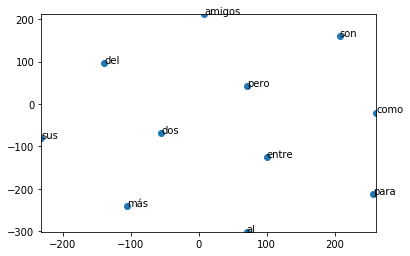

In [47]:
display_closestwords_tsnescatterplot(word2vec_model, 'amigos')

### 5.3. Clustering

In [48]:
from sklearn.cluster import KMeans
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 3.92 s, sys: 36 ms, total: 3.96 s
Wall time: 3.97 s


In [49]:
from sklearn.externals import joblib

#Salvamos nuestro modelo, o bien lo cargamos si ya lo hemos ejecutado previamente
joblib.dump(km,  'doc_cluster.pkl')
#km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

Construimos un pandas dataframe para que sea más cómodo trabajar

In [50]:
films = {'title':  list(info_pelis.titulo),
         'synopsis': list(info_pelis.descripcion), 
         'edition': list(info_pelis.edicion), 
         'cluster': clusters, 
         'nom_mejor_pelicula': list(info_pelis.nom_mejor_pelicula), 
         'nom_mejor_dire': list(info_pelis.nom_mejor_direc), 
         'gana_mejor_pelicula': list(info_pelis.gana_mejor_pelicula)}

frame = pd.DataFrame(films, index = [clusters] , columns = ['title', 'synopsis', 'edition', 'cluster', 'nom_mejor_pelicula','nom_mejor_dire', 'gana_mejor_pelicula'])

In [51]:
distribution_clusters = frame[['cluster', 'title']].groupby('cluster').count().reset_index() #numero de peliculas por cluster 
distribution_clusters_nom = frame[frame.nom_mejor_pelicula==1][['cluster', 'title']].groupby('cluster').count().reset_index() #numero de peliculas nominadas a mejor pelicula por cluster

Exploramos el resultado de la clusterización

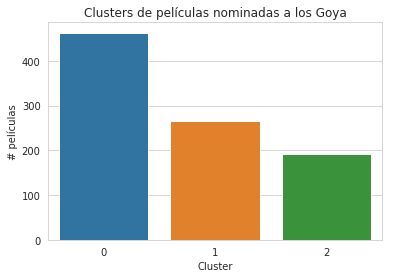

In [52]:
sns.set_style("whitegrid")
ax = sns.barplot(x="cluster", y="title", data=distribution_clusters)
ax.set(ylabel='# películas', xlabel='Cluster')
ax.set_title('Clusters de películas nominadas a los Goya')
plt.show()
plt.close()

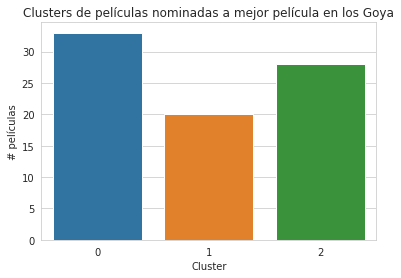

In [53]:
sns.set_style("whitegrid")
ax = sns.barplot(x="cluster", y="title", data=distribution_clusters_nom)
ax.set(ylabel='# películas', xlabel='Cluster')
ax.set_title('Clusters de películas nominadas a mejor película en los Goya')
plt.show()
plt.close()

In [54]:
print('Cluster 0: ')
print(list(frame[(frame.cluster==0) & (frame.nom_mejor_pelicula ==1)].title))
print('Cluster 1: ')
print(list(frame[(frame.cluster==1) & (frame.nom_mejor_pelicula ==1)].title))
print('Cluster 2: ')
print(list(frame[(frame.cluster==2) & (frame.nom_mejor_pelicula ==1)].title))

Cluster 0: 
['El autor', 'Estiu 1993', 'Julieta', 'Que Dios nos perdone', 'La novia', 'Truman', 'Loreak', 'Relatos salvajes', 'Caníbal', 'La herida', 'Grupo 7', 'La piel que habito', 'No habrá paz para los malvados', 'Balada triste de trompeta', 'Pa negre', 'Celda 211', 'El secreto de sus ojos', 'Las 13 rosas', 'La vida secreta de las palabras', 'La mala educación', 'Roma', 'Tiovivo c. 1950', 'Mi vida sin mí', 'Soldados de Salamina', 'Te doy mis ojos', 'Hable con ella', 'Los lunes al sol', 'Juana la Loca', 'Los otros', 'Lucía y el sexo', 'Sin noticias de Dios', 'La comunidad', 'Solas']
Cluster 1: 
['Verónica', 'Tarde para la ira', 'Nadie quiere la noche', 'Un día perfecto', 'El Niño', 'Magical Girl', 'La gran familia española', 'Vivir es fácil con los ojos cerrados', 'El artista y la modelo', 'También la lluvia', 'Agora', 'El baile de la Victoria', 'Camino', 'Los crímenes de Oxford', 'Sólo quiero caminar', 'Obaba', 'Princesas', 'Planta 4', 'Leo', 'Todo sobre mi madre']
Cluster 2: 
['Ha

In [55]:
# sólo las películas nominadas a mejor película
frame_nom = frame[frame.nom_mejor_pelicula==1]

In [56]:
over_edition = frame[['edition', 'cluster', 'title']].groupby(['edition', 'cluster']).count().reset_index()

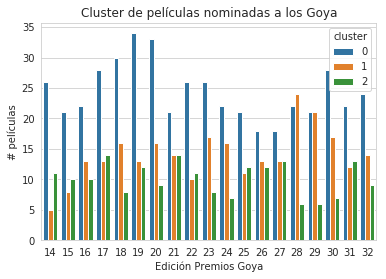

In [57]:
sns.set_style("whitegrid")
ax = sns.barplot(x="edition", y="title", hue="cluster", data=over_edition)
ax.set(ylabel='# películas', xlabel='Edición Premios Goya')
ax.set_title('Cluster de películas nominadas a los Goya')
plt.show()
plt.close()

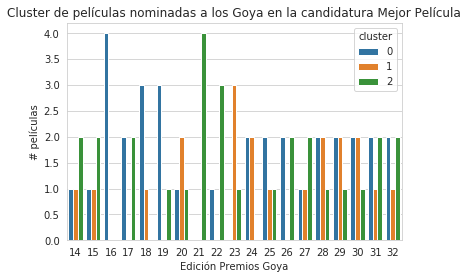

In [73]:
sns.set_style("whitegrid")
ax = sns.barplot(x="edition", y="title", hue="cluster", data=frame[frame.nom_mejor_pelicula==1][['edition', 'cluster', 'title']].groupby(['edition', 'cluster']).count().reset_index())
ax.set(ylabel='# películas', xlabel='Edición Premios Goya')
ax.set_title('Cluster de películas nominadas a los Goya en la candidatura Mejor Película')
plt.show()
plt.close()

In [74]:
# nominadas en cada cluster y pct de ganadoras del premio Goya a mejor película
frame_nom[['cluster', 'gana_mejor_pelicula']].groupby(['cluster']).agg(['count', 'sum', 'mean']).reset_index()

cluster gana_mejor_pelicula               
                        count  sum      mean
0       0                  33  9.0  0.272727
1       1                  20  5.0  0.250000
2       2                  28  8.0  0.285714

#### ¿Cuáles son los términos que hay detrás del clúster?

In [84]:
from __future__ import print_function

# frame.index = range(len(frame.index))

print("Palabras top por cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
for i in range(num_clusters):
    print("Palabras Cluster %d :" % i, end='')
    
    for ind in order_centroids[i, :15]: #15 palabras por cluster
        print(' %s' % str(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0]), end=',')
    print()
    print()
    
#     print("Cluster %d titles:" % i, end='')
#     for title in frame.ix[i]['title'].values.tolist():
#         print(' %s,' % title, end='')
#     print() #add whitespace
#     print() #add whitespace


Palabras top por cluster:

Palabras Cluster 0 : mundo, casa, encontrando, amor, personas, descubre, ciudad, cambiarán, noche, guerra, busca, muerte, acaba, prepara, abandonar,

Palabras Cluster 1 : chica, decide, amigas, viaje, llegan, aventuras, jugado, soñado, descubre, casa, cambiarán, mundo, sale, emprenden, dejando,

Palabras Cluster 2 : familia, pueblo, regresa, muere, contada, pequeña, casa, llegan, descubre, mundo, luchado, decide, guerra, amor, pequeña,



In [85]:
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

MDS()

# Convertimos el resultado en 2 componentes para poder representarlo

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [86]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Familia y costumbrismo', 
                 1: 'Amor y aventura', 
                 2: 'Histórico, sucesos y acción '
                }

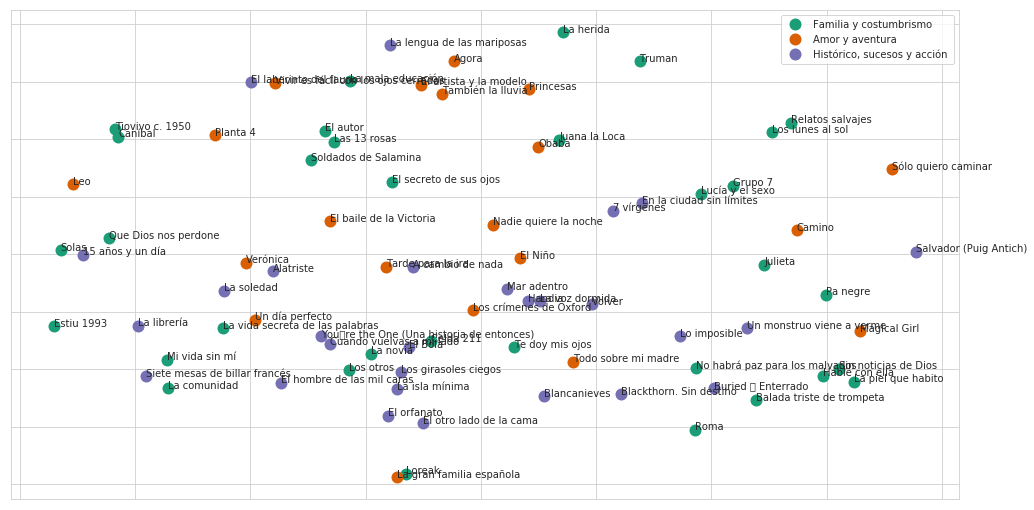

In [91]:
%matplotlib inline 

#crear dataframe, con los resultados de la descomposicion y otra información
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=list(frame.title),
                       nom_mejor_pelicula = list(frame.nom_mejor_pelicula),
                       gana_mejor_pelicula = list(frame.gana_mejor_pelicula),
                      ))
df = df[df.nom_mejor_pelicula==1]
df.index = range(len(df.index))

#agrupamos por cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',     
        bottom=False,     
        top=False,        
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',        
        which='both',     
        left=False,      
        top=False,       
        labelleft=False)
    
ax.legend(numpoints=1)  

for i in range(len(df)):
    ax.text(df.iloc[i]['x'], 
            df.iloc[i]['y'],
            df.iloc[i]['title'], size=10)  
  
    
plt.show()
plt.close()

### 5.4. Clustering jerárquico

El [método Ward](https://es.wikipedia.org/wiki/Método_de_Ward) es un algoritmo de clustering jerárquico. Nos permite en cada etapa identificar el par de clusters con la mínima distancia. Para realizarlo emplearemos la distancia previamente calculada. 

Devuelve 2 clusters principales, reemplazando a los 5 anteriores

In [92]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation="right", labels=list(info_pelis.titulo));

plt.tick_params(\
    axis= 'x',    
    which='both', 
    bottom=False, 
    top=False,    
    labelbottom=False)

plt.tight_layout()

plt.savefig('ward_clusters.png', dpi=500) 
plt.close()

### 5.5 Ejercicio
Realizar el mismo análisis pero con word2vec.

<img src="ward_clusters.png" alt="Logo" style="width: 500px;"/>

## 6. Topic modelling

Latent Dirichlet Allocation (LDA) es un modelo generativo que permite que conjuntos de observaciones puedan ser explicados por grupos no observados que explican por qué algunas partes de los datos son similares. Por ejemplo, si las observaciones son palabras en documentos, presupone que cada documento es una mezcla de un pequeño número de categorías (también denominados como tópicos/temas) y la aparición de cada palabra en un documento se debe a una de las categorías a las que el documento pertenece.  

<img src="lda.jpg" alt="LDA" style="width: 500px;"/>

In [93]:
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [94]:
def strip_proppers_spacy(text):
    token_list = []
    doc = nlp(text)
    for token in doc:
        if token.is_stop == False and token.is_alpha == True and token.pos_ not in ['PROPN', 'CONJ', 'ADP', 'DET']:
            token_list.append(token.text.lower())
    return ' '.join(token_list)

In [95]:
from nltk.tag import pos_tag
def strip_proppers_POS(text):
    tagged = pos_tag(text.split())
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [96]:
from gensim import corpora, models, similarities 

#quitar los nombres propios
%time preprocess = [strip_proppers_spacy(doc) for doc in synopses]

#tokenizar
%time tokenized_text = [tokenize_and_lemm_spacy(text) for text in preprocess]

#quitar las stopwords
%time texts = [[word for word in text if word not in MY_STOP_WORDS] for text in tokenized_text]

CPU times: user 25.9 s, sys: 0 ns, total: 25.9 s
Wall time: 25.9 s
CPU times: user 15.9 s, sys: 0 ns, total: 15.9 s
Wall time: 15.9 s
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 18.4 ms


In [97]:
#crear un diccionario de Gemsim a partir de los documentos
dictionary = corpora.Dictionary(texts)

#quitar los extremos ( similar al min max fijado en el tf-idf)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convertir el diccionario en 'bag of words corpus' para usarlo como referencia
corpus = [dictionary.doc2bow(text) for text in texts]

In [98]:
%time lda = models.LdaModel(corpus, num_topics=3, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 2min 32s, sys: 0 ns, total: 2min 32s
Wall time: 2min 32s


In [99]:
lda.show_topics()

[(0,
  '0.007*"casar" + 0.006*"llegar" + 0.006*"descubrir" + 0.005*"familia" + 0.005*"pequeño" + 0.005*"mundo" + 0.004*"cambiar" + 0.004*"poblar" + 0.004*"decidir" + 0.004*"chico"'),
 (1,
  '0.004*"mundo" + 0.004*"llegar" + 0.003*"encontrar" + 0.003*"convertir" + 0.003*"muerte" + 0.003*"acabar" + 0.003*"político" + 0.003*"casar" + 0.003*"descubrir" + 0.003*"guerra"'),
 (2,
  '0.007*"viajar" + 0.005*"amor" + 0.005*"mundo" + 0.004*"amigo" + 0.004*"familia" + 0.004*"casar" + 0.004*"encontrar" + 0.003*"descubrir" + 0.003*"ciudad" + 0.003*"decidir"')]

# REFERENCIAS

* [NLTK book](http://www.nltk.org/book/)
* [SpaCy 101](https://spacy.io/usage/spacy-101)
* [SpaCy tutorial](https://www.analyticsvidhya.com/blog/2017/04/natural-language-processing-made-easy-using-spacy-%E2%80%8Bin-python/)
* [Textblob](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/)
* [NLP essential](https://www.analyticsvidhya.com/blog/2017/10/essential-nlp-guide-data-scientists-top-10-nlp-tasks/)
* [Document clustering](http://brandonrose.org/clustering)

    

# ¡¡¡GRACIAS POR VUESTRA ATENCIÓN!!!!

[PANDAS DOCUMENTATION SPRINT](https://www.meetup.com/es/PyData-Madrid/events/247525766/?eventId=247525766)

<img src="pandas_logo.png" alt="pandas logo" style="width: 500px;"/>